In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from tqdm import tqdm

In [18]:
ratings_train = np.load("data/ratings_train.npy")
ratings_test = np.load("data/ratings_test.npy")
print(ratings_train.shape)
print(f"% of missing values for the training matrix : {np.isnan(ratings_train).sum()/(ratings_train.shape[0]*ratings_train.shape[1])}")
print(ratings_test.shape)
print(f"% of missing values for the testing matrix : {np.isnan(ratings_test).sum()/(ratings_test.shape[0]*ratings_test.shape[1])}")
names_genres = np.load("data/namesngenre.npy")
print(names_genres)

(610, 4980)
% of missing values for the training matrix : 0.9895983935742972
(610, 4980)
% of missing values for the testing matrix : 0.9895983935742972
[['Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
 ['Jumanji (1995)' 'Adventure|Children|Fantasy']
 ['Grumpier Old Men (1995)' 'Comedy|Romance']
 ...
 ['Elsa & Fred (2005)' 'Comedy|Drama|Romance']
 ['Tomb Raider (2018)' 'Action|Adventure|Fantasy']
 ['Fred Armisen: Standup for Drummers (2018)' 'Comedy']]


In [19]:
class AutoRecEncoder(nn.Module) :
    def __init__(self, d, k, dropout) :
        super().__init__()
        self.encoder=nn.Sequential(
        nn.Linear(d,k),
        nn.Sigmoid(), # Can be changed
        nn.Dropout(dropout))
        self.decoder=nn.Linear(k,d)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
def get_mask(ratings):
    mask = ~torch.isnan(ratings)  # True là où il y a une valeur, False là où il y a un NaN
    ratings = torch.nan_to_num(ratings, nan=0.0)  # Remplace temporairement les NaN par 0
    return ratings, mask.float()

def compute_rmse(pred, true, mask):
    # On ne considère que les valeurs observées (où mask = 1)
    loss = torch.sum(((pred - true) ** 2) * mask) / torch.sum(mask)
    return torch.sqrt(loss)


In [21]:
# ratings_train = torch.Tensor(np.load("ratings_train.npy"))

# num_movies = ratings_train.shape[1]  # Pour user-based
# num_users = ratings_train.shape[0]    # Pour item-based

# ratings_train, train_mask = get_mask(ratings_train.T)

# nb_epochs = 300
# verbose = False
# batch_size = 32
# device = "cuda"
# train_dataset = TensorDataset(ratings_train, train_mask)
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# all_loss_values = {}

# for hidden_space_dimension in [100, 250, 500, 700]:
#     model = AutoRecEncoder(num_users, hidden_space_dimension, dropout=False)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
#     model = model.to(device)
#     pbar = tqdm(range(nb_epochs))
    
#     loss_values = []
#     for epoch in pbar:
#         model.train()
#         epoch_loss = 0
#         for batch_ratings, batch_mask in train_loader:
#             batch_ratings = batch_ratings.to(device)
#             batch_mask = batch_mask.to(device)
#             optimizer.zero_grad()
#             output_matrix = model(batch_ratings)
#             loss = compute_rmse(output_matrix, batch_ratings, batch_mask)
#             epoch_loss += loss.item()
#             loss.backward()
#             optimizer.step()
        
#         epoch_loss /= len(train_loader)
#         pbar.set_description(f"Hidden_space_dimension: {hidden_space_dimension}. Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
#         loss_values.append(epoch_loss)

#         if verbose:
#             if (epoch + 1) % 10 == 0:
#                 print(f"loss at epoch {epoch + 1}: {epoch_loss}")

#     all_loss_values[hidden_space_dimension] = loss_values

# plt.figure(figsize=(10, 5))
# for hidden_space_dimension, loss_values in all_loss_values.items():
#     plt.plot(loss_values, label=f'Hidden Space: {hidden_space_dimension}')
# plt.title('Courbe d\'apprentissage')
# plt.xlabel('Époques')
# plt.ylabel('Perte RMSE')
# plt.legend()
# plt.grid()
# plt.show()


### Early stopping and fixed hidden space

4980


Hidden_space_dimension: 500. Epoch 10, Loss: 0.5293:  10%|█         | 10/100 [00:02<00:20,  4.47it/s]

1.0660173892974854 100000.0
Saved weights at epoch 10


Hidden_space_dimension: 500. Epoch 100, Loss: 0.2226: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


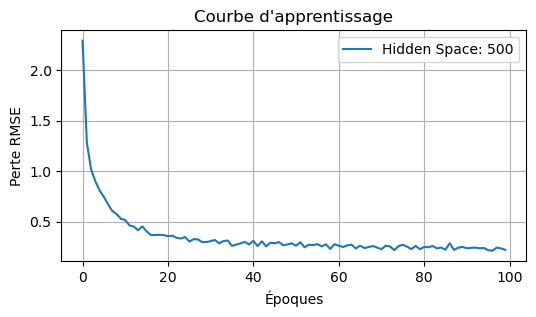

In [26]:
from copy import deepcopy

user_based = False
if user_based : 
    ratings_train = torch.Tensor(np.load("data/ratings_train.npy"))
    num_users = ratings_train.shape[0]    # Pour user-based
    num_movies = ratings_train.shape[1]  # Pour item-based
    input_dim = num_movies
else :
    ratings_train = torch.Tensor(np.load("data/ratings_train.npy")).T #item_based
    num_users = ratings_train.shape[1]    # Pour user-based
    num_movies = ratings_train.shape[0]  # Pour item-based
    input_dim = num_users
ratings_train, train_mask = get_mask(ratings_train)
print(input_dim)

nb_epochs = 100
early_stopping = True
batch_size = 32
device = "cuda"
train_dataset = TensorDataset(ratings_train, train_mask)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

all_loss_values = {}
best_rmse = 1e5
best_model = None

for hidden_space_dimension in [500]:
    model = AutoRecEncoder(input_dim, hidden_space_dimension, dropout=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)
    model = model.to(device)
    pbar = tqdm(range(nb_epochs))
    
    loss_values = []
    for epoch in pbar:
        model.train()
        epoch_loss = 0
        for batch_ratings, batch_mask in train_loader:
            batch_ratings = batch_ratings.to(device)
            batch_mask = batch_mask.to(device)
            optimizer.zero_grad()
            output_matrix = model(batch_ratings)
            loss = compute_rmse(output_matrix, batch_ratings, batch_mask)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        epoch_loss /= len(train_loader)
        pbar.set_description(f"Hidden_space_dimension: {hidden_space_dimension}. Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
        loss_values.append(epoch_loss)

        if early_stopping:
            if (epoch + 1) % 10 == 0:
                #print(f"loss at epoch {epoch + 1}: {epoch_loss}")
                if user_based :
                    ratings_test = torch.Tensor(np.load("data/ratings_test.npy"))
                else :
                    ratings_test = torch.Tensor(np.load("data/ratings_test.npy")).T                
                ratings_test, mask_test = get_mask(ratings_test)
                model.eval()
                with torch.no_grad():
                    predictions_test = model(ratings_test.to(device))
                predictions_test_rounded = (predictions_test.clone() *2).round()/2
                test_loss = compute_rmse(predictions_test_rounded, ratings_test.to(device), mask_test.to(device))
                if test_loss.item() < best_rmse :
                    print(test_loss.item(), best_rmse)
                    best_rmse = test_loss
                    best_model = deepcopy(model)
                    torch.save(model.state_dict(), f"best_model_hsd{hidden_space_dimension}.pth")
                    print(f"Saved weights at epoch {epoch+1}")

    all_loss_values[hidden_space_dimension] = loss_values

plt.figure(figsize=(6, 3))
for hidden_space_dimension, loss_values in all_loss_values.items():
    plt.plot(loss_values, label=f'Hidden Space: {hidden_space_dimension}')
plt.title('Courbe d\'apprentissage')
plt.xlabel('Époques')
plt.ylabel('Perte RMSE')
plt.legend()
plt.grid()
plt.show()


In [27]:
def compute_accuracy(pred, true, mask) :
    accuracy = torch.sum((pred==true)*mask)/torch.sum(mask)
    return accuracy.item()

In [29]:
ratings_test = torch.Tensor(np.load("data/ratings_test.npy"))
ratings_test, mask_test = get_mask(ratings_test.T)
best_model.eval()
with torch.no_grad():
    predictions_test = best_model(ratings_test.to(device))
test_loss = compute_rmse(predictions_test, ratings_test.to(device), mask_test.to(device))
print(f"Test RMSE: {test_loss.item()}")
predictions_test_rounded = (predictions_test.clone() *2).round()/2
test_loss = compute_rmse(predictions_test_rounded, ratings_test.to(device), mask_test.to(device))
print(f"Test RMSE avec arrondis: {test_loss.item()}")
compute_accuracy(predictions_test_rounded, ratings_test.to(device), mask_test.to(device))


Test RMSE: 1.0551573038101196
Test RMSE avec arrondis: 1.0660173892974854


0.1993480622768402